In [3]:
import os, shutil
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
file_path = []
labels = []

In [5]:
cancer_dir = './Brain Tumor'
healthy_dir = './Healthy'

In [6]:
dir_list = [cancer_dir, healthy_dir]

In [7]:
for i, j in enumerate(dir_list) :
  files = os.listdir(j)

  for file in files :
    fpath = os.path.join(j, file)
    file_path.append(fpath)

    if i == 0 :
      labels.append('cancer')
    else :
      labels.append('healthy')

In [8]:
data = pd.DataFrame({'file_path' : file_path, 'label' : labels})

In [9]:
data

,file_path,label
0,./Brain Tumor/Cancer (503).jpg,cancer
1,./Brain Tumor/Cancer (515).jpg,cancer
2,./Brain Tumor/Cancer (520).jpg,cancer
3,./Brain Tumor/Cancer (328).jpg,cancer
4,./Brain Tumor/Cancer (246).jpg,cancer
...,...,...
4595,./Healthy/Not Cancer (1022).jpg,healthy
4596,./Healthy/Not Cancer (1047).jpg,healthy
4597,./Healthy/Not Cancer (1087).jpg,healthy
4598,./Healthy/Not Cancer (103).jpg,healthy


In [10]:
tr_set, val_set = train_test_split(data, random_state = 42, test_size = 0.2, stratify = data['label'])

In [11]:
from tensorflow.keras.applications import mobilenet_v2

In [12]:
img_gen = ImageDataGenerator(preprocessing_function = mobilenet_v2.preprocess_input)

In [13]:
tr_gen = img_gen.flow_from_dataframe(dataframe = tr_set, x_col = 'file_path', y_col = 'label',
                                          target_size = (224, 224), color_mode = 'rgb',
                                          class_mode = 'binary', batch_size = 64, shuffle = True)

Found 3680 validated image filenames belonging to 2 classes.


In [14]:
val_gen = img_gen.flow_from_dataframe(dataframe = val_set, x_col = 'file_path', y_col = 'label',
                                          target_size = (224, 224), color_mode = 'rgb',
                                          class_mode = 'binary', batch_size = 64, shuffle = True)

Found 920 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
img_size = (224, 224)

In [ ]:
vgg19 = VGG19(include_top = False, input_shape = img_size + (3, ))

In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 1)
mc = ModelCheckpoint('best_vgg19.h5', patience = 5, monitor = 'val_acc', mode = 'max', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(tr_gen, validation_data = val_gen, epochs = 50, verbose = 1, callbacks = [es, mc])

Epoch 1/50
58/58 [==============================] - 955s 16s/step - loss: 0.7543 - acc: 0.7068 - val_loss: 0.2686 - val_acc: 0.8837

Epoch 00001: val_acc improved from -inf to 0.88370, saving model to best_vgg19.h5
Epoch 2/50
58/58 [==============================] - 38s 660ms/step - loss: 0.3445 - acc: 0.8573 - val_loss: 0.1839 - val_acc: 0.9359

Epoch 00002: val_acc improved from 0.88370 to 0.93587, saving model to best_vgg19.h5
Epoch 3/50
58/58 [==============================] - 39s 666ms/step - loss: 0.2792 - acc: 0.8880 - val_loss: 0.3709 - val_acc: 0.8478

Epoch 00003: val_acc did not improve from 0.93587
Epoch 4/50
58/58 [==============================] - 39s 663ms/step - loss: 0.2237 - acc: 0.9144 - val_loss: 0.1598 - val_acc: 0.9424

Epoch 00004: val_acc improved from 0.93587 to 0.94239, saving model to best_vgg19.h5
Epoch 5/50
58/58 [==============================] - 39s 664ms/step - loss: 0.1674 - acc: 0.9329 - val_loss: 0.1211 - val_acc: 0.9554

Epoch 00005: val_acc improved

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

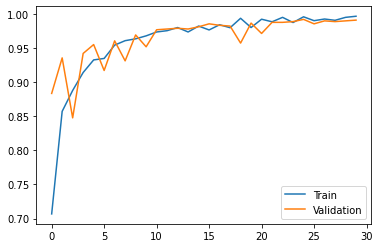

In [ ]:
plt.plot(acc, label = 'Train')
plt.plot(val_acc, label = 'Validation')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

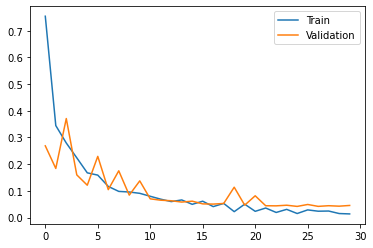

In [ ]:
plt.plot(loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
resnet = ResNet50(include_top = False, weights = None, input_shape=(224, 224, 3), pooling = max, classes = 2)

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam') 

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 1)
mc = ModelCheckpoint('best_resnet.h5', patience = 5, monitor = 'val_acc', mode = 'max', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(tr_gen, validation_data = val_gen, epochs = 50, verbose = 1, callbacks = [es, mc])

Epoch 1/50
58/58 [==============================] - 39s 579ms/step - loss: 0.7104 - acc: 0.5549 - val_loss: 0.6638 - val_acc: 0.5946

Epoch 00001: val_acc improved from -inf to 0.59457, saving model to best_resnet.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
58/58 [==============================] - 31s 529ms/step - loss: 0.5744 - acc: 0.7120 - val_loss: 0.5701 - val_acc: 0.6859

Epoch 00002: val_acc improved from 0.59457 to 0.68587, saving model to best_resnet.h5
Epoch 3/50
58/58 [==============================] - 31s 526ms/step - loss: 0.5297 - acc: 0.7549 - val_loss: 0.5218 - val_acc: 0.8087

Epoch 00003: val_acc improved from 0.68587 to 0.80870, saving model to best_resnet.h5
Epoch 4/50
58/58 [==============================] - 31s 527ms/step - loss: 0.4901 - acc: 0.7913 - val_loss: 0.4798 - val_acc: 0.7924

Epoch 00004: val_acc did not improve from 0.80870
Epoch 5/50
58/58 [==============================] - 31s 532ms/step - loss: 0.4610 - acc: 0.8122 - val_loss: 0.4552 - val_acc: 0.8283

Epoch 00005: val_acc improved from 0.80870 to 0.82826, saving model to best_resnet.h5
Epoch 6/50
58/58 [==============================] - 31s 536ms/step - loss: 0.4458 - acc: 0.8117 - val_loss: 0.4365 - val_acc: 0.8402

Epoch 00006: val_acc i

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

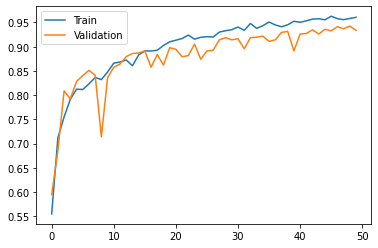

In [ ]:
plt.plot(acc, label = 'Train')
plt.plot(val_acc, label = 'Validation')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

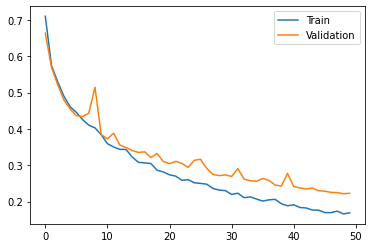

In [ ]:
plt.plot(loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.legend()
plt.show()

In [49]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3), padding = 'same'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3, 3), activation = 'relu', padding = 'same')) 
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation = 'relu',padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same')) 
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))

In [50]:
model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam') 

In [51]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 37, 37, 64)        256       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 37, 128)      

In [52]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest')

In [53]:
tr_gen = train_datagen.flow_from_dataframe(dataframe = tr_set, x_col = 'file_path', y_col = 'label',
                                          target_size = (150, 150), color_mode = 'rgb',
                                          class_mode = 'binary', batch_size = 64, shuffle = True)

Found 3680 validated image filenames belonging to 2 classes.


In [54]:
validation_datagen = ImageDataGenerator(rescale=1/255)

In [55]:
val_gen = validation_datagen.flow_from_dataframe(dataframe = val_set, x_col = 'file_path', y_col = 'label',
                                          target_size = (150, 150), color_mode = 'rgb',
                                          class_mode = 'binary', batch_size = 64, shuffle = True)

Found 920 validated image filenames belonging to 2 classes.


In [56]:
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 1)
mc = ModelCheckpoint('best_cnn.h5', patience = 5, monitor = 'val_acc', mode = 'max', save_best_only = True, verbose = 1)

In [57]:
history = model.fit_generator(tr_gen, validation_data = val_gen, epochs = 50, verbose = 1, callbacks = [es, mc])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
58/58 [==============================] - 42s 673ms/step - loss: 0.8183 - acc: 0.5712 - val_loss: 0.6944 - val_acc: 0.5467

Epoch 00001: val_acc improved from -inf to 0.54674, saving model to best_cnn.h5
Epoch 2/50
58/58 [==============================] - 38s 654ms/step - loss: 0.6757 - acc: 0.6041 - val_loss: 0.7068 - val_acc: 0.5467

Epoch 00002: val_acc did not improve from 0.54674
Epoch 3/50
58/58 [==============================] - 38s 653ms/step - loss: 0.6184 - acc: 0.6644 - val_loss: 0.9403 - val_acc: 0.5467

Epoch 00003: val_acc did not improve from 0.54674
Epoch 4/50
58/58 [==============================] - 38s 655ms/step - loss: 0.5948 - acc: 0.6929 - val_loss: 0.6599 - val_acc: 0.5478

Epoch 00004: val_acc improved from 0.54674 to 0.54783, saving model to best_cnn.h5
Epoch 5/50
58/58 [==============================] - 38s 649ms/step - loss: 0.5640 - acc: 0.7212 - val_loss: 0.7858 - val_acc: 0.5446

Epoch 00005: val_acc did not improve from 0.54783
Epoch 6/50
58/58 

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']

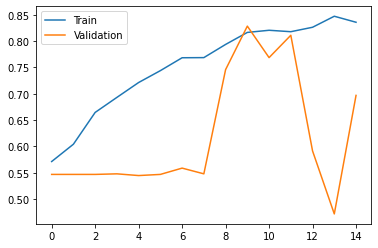

In [62]:
plt.plot(acc, label = 'Train')
plt.plot(val_acc, label = 'Validation')
plt.legend()
plt.show()

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

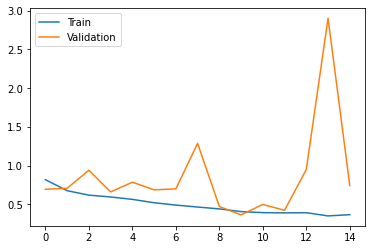

In [63]:
plt.plot(loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.legend()
plt.show()